## Initial Local Creation of Bayesian Network

## HC + BIC

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [1]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score


c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data importing and preprocessing

In [2]:
loaded_data = myData.load_data(num_rows = 200)
#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, test_data = myData.split_data(data)

<class 'pandas.core.frame.DataFrame'>


### Structure Learning

In [3]:
scoring_method = estimators.BicScore(data=train_data)
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2))
model = pgmpy.models.BayesianNetwork(estimated_model.edges())
print(model.nodes())
print(model.edges())

  7%|▋         | 7/100 [01:36<21:15, 13.72s/it]

['home_ownership', 'debt_settlement_flag', 'loan_status', 'term', 'out_prncp_inv', 'out_prncp', 'tax_liens', 'pub_rec', 'collection_recovery_fee', 'recoveries']
[('home_ownership', 'debt_settlement_flag'), ('debt_settlement_flag', 'collection_recovery_fee'), ('debt_settlement_flag', 'recoveries'), ('loan_status', 'term'), ('out_prncp_inv', 'out_prncp'), ('out_prncp_inv', 'loan_status'), ('tax_liens', 'pub_rec')]


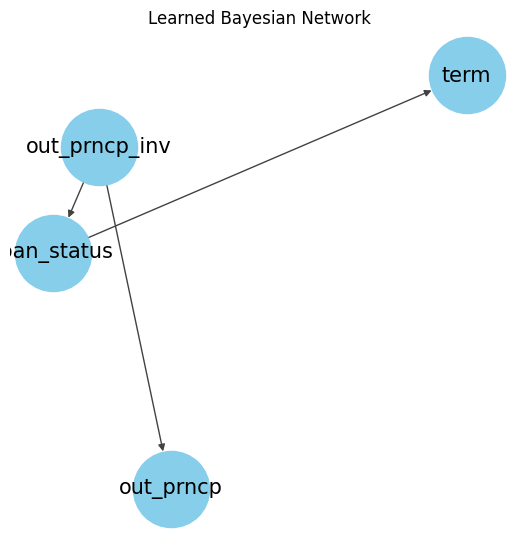

In [4]:
active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
active_trail_nodes_list = list(active_trail_nodes)
original_nodes = list(model.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        model.remove_node(node)
        

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(5, 5))
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [5]:
parameter_estimator = estimators.BayesianEstimator(model,train_data)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    print(parameters[i])

+------------------------------+-----+---------------------+
| out_prncp_inv                | ... | out_prncp_inv(9)    |
+------------------------------+-----+---------------------+
| loan_status(Charged Off)     | ... | 0.09615384615384616 |
+------------------------------+-----+---------------------+
| loan_status(Current)         | ... | 0.7115384615384616  |
+------------------------------+-----+---------------------+
| loan_status(Fully Paid)      | ... | 0.09615384615384616 |
+------------------------------+-----+---------------------+
| loan_status(In Grace Period) | ... | 0.09615384615384616 |
+------------------------------+-----+---------------------+
+------------------+-----+------------------------------+
| loan_status      | ... | loan_status(In Grace Period) |
+------------------+-----+------------------------------+
| term( 36 months) | ... | 0.2777777777777778           |
+------------------+-----+------------------------------+
| term( 60 months) | ... | 0.7222222222

### Inference

In [17]:
testing_evidence_list = myData.get_evidence_list(test_data, target_label="loan_status")


for i in range(len(testing_evidence_list)):
    for attribute in list(testing_evidence_list[i].keys()):
        if attribute not in model.nodes():
            del testing_evidence_list[i][attribute]
            
inference = VariableElimination(model)

y_pred = []
y_true = []

for i in range(len(testing_evidence_list)):
    loan_status = inference.map_query(['loan_status'], evidence = testing_evidence_list[i], show_progress= True) 
    y_pred.append(loan_status['loan_status'])
    y_true.append(test_data['loan_status'].iloc[i])
    

TypeError: DataPreprocessing.get_evidence_list() got an unexpected keyword argument 'target_label'

## Testing

In [15]:
data_testing_corr_score = model.simulate(int(1e4))
correlation_score_value = correlation_score(model, data_testing_corr_score, test="log_likelihood", significance_level=0.05)
log_likelihood_score_value = log_likelihood_score(model, data_testing_corr_score)
structure_score_value = structure_score(model, data_testing_corr_score, scoring_method="bic")
print("correlation score: " + str(correlation_score_value))
print("Log likelihood score: " + str(log_likelihood_score_value))
print("Structure score: "+ str(structure_score_value))

accuracy_score_value = accuracy_score(y_true, y_pred)
f1score_value = f1_score(y_true, y_pred, average = None)
precisionScore = precision_score(y_true, y_pred,average = None)
recallScore = recall_score(y_true, y_pred,average = None)
#roc_auc_score_value =  roc_auc_score(y_true, y_pred,average = None)
balanced_accuracy_score_value = balanced_accuracy_score(y_true, y_pred, adjusted=True)

f1_score_macro = f1_score(y_true, y_pred, average='macro')
precision_score_macro = precision_score(y_true, y_pred, average='macro')
recall_score_macro = recall_score(y_true, y_pred, average='macro')

f1_score_weighted = f1_score(y_true, y_pred, average = 'weighted')
precision_score_weighted = precision_score(y_true, y_pred, average = 'weighted')
recall_score_weighted = recall_score(y_true, y_pred, average = 'weighted')

print("accuracy score: "+str(accuracy_score_value))
print("f1_score: "+str(f1score_value))
print("precision score: "+str(precisionScore))
print("recall score: "+str(recallScore))
#print("roc auc score: "+str(roc_auc_score_value))
print("balanced_accuracy_score: " + str(balanced_accuracy_score_value))
print("\n\n")
print("Macro scores:\n")
print("recall_score_macro: "+str(recall_score_macro))
print("f1_score_macro: "+str(f1_score_macro))
print("precision_score_macro: "+str(precision_score_macro))
print("\n")
print("Weighted Scores:\n")
print("recall_score_weighted: "+str(recall_score_weighted))
print("f1_score_weighted: "+str(f1_score_weighted))
print("precision_score_weighted: "+str(precision_score_weighted))

accuracy score: 0.8
['Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid']
['Fully Paid', 'Fully Paid', 'Charged Off', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Charged Off', 'Fully Paid', 'Fully Paid', 'Charged Off', 'Fully Paid', 'Fully Paid', 'Fully Paid', 'Fully Paid']
accuracy score: 0.8
f1_score: [0.         0.88888889]
precision score: [0.  0.8]
recall score: [0. 1.]
balanced_accuracy_score: 0.0



Macro scores:

recall_score_macro: 0.5
f1_score_macro: 0.4444444444444444
precision_score_macro: 0.4


Weighted Scores:

recall_score_weighted: 0.8
f1_score_weighted: 0.711111111111111
precision_score_weighted: 0.6400000000000001


c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo